In [1]:
from utils import feature_importances, plot_model_performances, set_up_entityset

from featuretools.primitives import RollingMean, NumericLag
from IPython.display import Image
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error
import evalml
import featuretools as ft
import pandas as pd
import matplotlib.pylab as plt
import woodwork as ww

/Users/tamar.grey/.pyenv/versions/3.8.2/envs/clean-env/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Using Featuretools and EvalML to Solve Time Series Problems

In this demo, we'll work to predict future daily average temperatures using historical temperature data. This is a time series machine learning problem, which requires special considerations during preprocessing, feature engineering, and model building.

To highlight the proess through which we can solve a time series problem, we'll build three models.

First, we'll build a baseline model; this will highlight the unique constraints for data-splitting and allow us to understand the problem definition. Then, we'll explore time series feature engineering by generating features with which we'll fit our model using [Featuretools](https://featuretools.alteryx.com/), an open-source Python library for automatically creating features out of a set of related tables using a technique called Deep Feature Synthesis. Finally, we'll use [EvalML](https://github.com/alteryx/evalml)'s time series modeling to greatly simplify the process through which these models are built.

## Understanding Time Series Problems

Time series forecasting is different from other machine learning problems in that there is an inherent temporal ordering to the data. The ordering comes from a time index column, so at a specific point in time, we may have knowlege about earlier observations but not later ones. If the data is unordered, it’d be hard to see any overall trend or seasonality, but when sorted by date, any relationships that exist in the data can be seen and used when making predictions (winter is cold; summer is hot!). Notice how this is different from non-time series data, which can be presented in any order without having an impact on the resulting predictions. Therefore, in time series problems, we need to set a `time_index` column that is just as important for defining our problem as the `target_column` is.

Other demos in this repository explore the time series concept some. For example, the [predict-remaining-useful-life](../predict-remaining-useful-life/README.md) demo is highly reliant on the temporal ordering of its data, as it is predicting when, in the future, an engine will need to be decommissioned. In that demo, the primary impact the data's temporal ordering has on modeling occurs in splitting the data into training and test data where we use a `cutoff_time` to determine when that split occurs and make sure no future values are exposed in the feature engineering process. We'll have to account for the same things in this demo since we have to be very careful when splitting our data to not expose future observations in the feature engineering stage. 

But once the data is split, the predict-remaining-useful-life demo calculates aggregations over the entire life of the engine up until the last available time. In that case, that makes sense! The goal is to predict one future value (the remaining useful life) per engine, so we should look at its entire available history when making that prediction. There is an entire dataframe of engines for which we're predicting this value, but the individual engines are not dependent on one another. 

However, in this demo and in many time series problems, we're trying to predict a sequential series of values that are highly dependent on one another. In these cases, we can exploit the fact that more recent observations are more predictive than more distant ones--when trying to determine tomorrow's temperature, knowing today's temperature may be the most predictive piece of information we can get. We also only have one table in our dataset, so any aggregations have to be calculated over earlier data from the same column. We'll see the impact of this in what types of features we choose to build in the expanded Featuretools run.

For additional examples of time series demos that are similar to predict-remaining-useful-life, see [predict-olympic-medals](../predict-olympic-medals/README.md) and [predict-appointment-noshow](../predict-appointment-noshow/README.md).

## Load in Data

We’ll demonstrate how to build a time series model using the DailyDelhiClimate dataset, which is a combination of the [Kaggle daily climate](https://www.kaggle.com/diegozurita/daily-climate-time-series) time series dataset's train and test data, since we'll be handling data splitting ourselves. This dataset contains a `meantemp` target variable and a `date` time index. There are other columns, but for the purposes of simplicity, we'll only work with the target and time index columns. To include the others would bring this demo into the sphere of multivariate time series modeling, which brings its own host of complexity.

In [2]:
file_name = "DailyDelhiClimate"
df = pd.read_csv(f"dataset/{file_name}.csv")

# The only columns we'll want to use for modeling - makes this a univariate problem
time_index = "date"
target_col = 'meantemp'
univariate_df = df[[time_index, target_col]]

univariate_df

,date,meantemp
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000
...,...,...
1570,2017-04-20,34.500000
1571,2017-04-21,34.250000
1572,2017-04-22,32.900000
1573,2017-04-23,32.875000


Now, we'll do a couple of quick checks that the data has some temporal pattern that we can exploit for modeling purposes.

First, we'll use a [Woodwork](https://woodwork.alteryx.com/en/stable/) method to check whether there is any column with a uniform sampling frequency. This is important, because it means that there is a constant amount of time between observations. A dataset that does not have a uniform sampling frequency can still be used for time series modeling, but the existence of that frequency is a good indicator that this dataset is ripe for time series modeling. For columns that have multiple datetime columns, checking for a frequency is also a good indicator for which could be the time index.

In [3]:
univariate_df.ww.init()
univariate_df.ww.infer_temporal_frequencies()

{'date': 'D'}

Indeed, one of the columns, `date`, has a daily frequency; we'll move forward with it as our time index.

Now, we’ll graph the data.

<AxesSubplot:xlabel='date'>

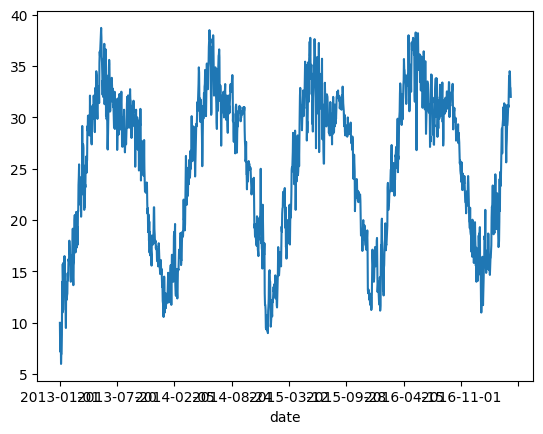

In [4]:
ts = df[target_col]
ts.index = df[time_index]
ts.plot()

We can see a strong seasonality, which makes sense for temperature data! In many places, the time of the year is indicative of how warm or cold we can expect it to be outside. We can exploit that seasonality in our feature engineering, but first, we'll build a baseline model that uses only the most recently available data.

But how do we define what data we have access to at different points in time? In many scenarios, this might be determined by how quickly we can get access to recent observations. Consider an example where we're recording data that takes a week to ingest; the earliest data we have access to is from seven days ago, so seven days would be our contraint for our baseline feature.

In this demo, we do not naturally have any of these constraints, so we'll need to set some parameters arbitrarily when formally defining the problem we're solving. But these parameters can be used on real data, where the contraints will define the problem. We'll stick with this problem configuration throughout the rest of the demo. 

## Problem Configuration
Here are a few concepts that give us our official problem configuration. They are taken from EvalML's [time series user guide](https://evalml.alteryx.com/en/stable/user_guide/timeseries.html#Running-AutoMLSearch):

**forecast_horizon**: The number of time periods we are trying to forecast.

**gap**: The number of time periods between the end of the training set and the start of the test set.

**max_delay**: The maximum number of rows to look in the past from the current row in order to compute features.

**time_index**: The column of the training dataset that contains the date corresponding to each observation. We set the time index along with the target column above; it's the `date` column.

Below is a visualization of the forecast horizon and gap on a timeline. The max delay is not shown, because it gets used in the feature engineering step to limit how far back in time we can look for each observation.

<p style="margin:30px">
    <img style="display:inline; margin-right:50px" width=80% src="figures/ts_parameter_viz.png" alt="ts" />
</p>

Our problem can be described as trying to predict the mean temperature 3 to 8 days out using temperature data from 20 days prior. With the concepts above in-hand, we can define our parameters as follows:

In [5]:
gap = 3
max_delay = 20
forecast_horizon = 5

## Data Splitting

Additionally, we'll want to have our data split up into training and testing data. We'll use the same split for both our baseline and Featuretools runs. We're leaving a `gap` number of observations between the train and test sets in order to not have the test dataset's delayed feature use values that are technically before the test set begins or inside of the training set. 

In [6]:
split_point = int(univariate_df.shape[0]*.8)

# leave gap observations between training and test datasets
training_data = univariate_df[:split_point]
test_data = univariate_df[(split_point + gap):]

training_data.head()

,date,meantemp
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000


# Baseline Run

Our baseline run will only include one feature that is a delayed value from the `meantemp` column. That delayed value will be the first known value for each observation. 

### Feature Engineering

In [7]:
# The delay includes the gap, because that's how many rows are skipped between train and test data.
# The forecast horizon is also present so that when we predict out a forecast_horizon number of observations into
# the future, we don't need to use predicted values to predict new values.
delay_length = forecast_horizon + gap + 1

# Add a delayed target feature to both traning and test data
target_delay_training = training_data[target_col].shift(delay_length)
target_delay_training.name = 'target_delay'
baseline_training = pd.concat([training_data, target_delay_training], axis=1)

target_delay_test = test_data[target_col].shift(delay_length)
target_delay_test.name = 'target_delay'
baseline_test = pd.concat([test_data, target_delay_test], axis=1)

baseline_training.head(13)

,date,meantemp,target_delay
0,2013-01-01,10.000000,NaN
1,2013-01-02,7.400000,NaN
2,2013-01-03,7.166667,NaN
3,2013-01-04,8.666667,NaN
4,2013-01-05,6.000000,NaN
5,2013-01-06,7.000000,NaN
6,2013-01-07,7.000000,NaN
7,2013-01-08,8.857143,NaN
8,2013-01-09,14.000000,NaN
9,2013-01-10,11.000000,10.000000


Notice how the `meantemp` value at index `0` is the same `target_delay` value at index `10`, the first non null value, since it's the first delayed value to be present in the original target column. 

### Format data for modeling

We won't want the time index column, `date`, in our data for modeling, we also need to remove the null values that were introduced in the delayed target feature, and last we need to pull the target column out. 

In [8]:
# Get rid of the time index column for modeling
baseline_training.drop(time_index, axis=1, inplace=True)
baseline_test.drop(time_index, axis=1, inplace=True)

# The lag feature introduces nans, so we remove those rows and pull out the target
X_train = baseline_training.dropna()
y_train = X_train.pop(target_col)

X_test = baseline_test.dropna()
y_test = X_test.pop(target_col)

X_train.head()

,target_delay
9,10.000000
10,7.400000
11,7.166667
12,8.666667
13,6.000000


### Model Building

Now that we've formatted our training and test data for modeling, we can use the training data, `X_train` and the target column `y_train`, to fit the random forest regressor we've chosen as our estimator. Then, we use the test data, `X_test` to predict our target values and check its accuracy against `y_test`.

In [9]:
reg = RandomForestRegressor(n_estimators=100)
reg.fit(X_train, y_train)

# Check the accuracy of our model
preds = reg.predict(X_test)
baseline_score = median_absolute_error(preds, y_test)
print('Median Abs Error: {:.2f}'.format(baseline_score))

Median Abs Error: 2.07


We're using median absolue error as our objective function for determining how the model performs. **The closer the score is to zero, the more accurate our model is.**

We can also learn a bit more about our model by looking at the feature importances. 

In [10]:
high_imp_feats = feature_importances(X_train, reg, feats=10)

1: target_delay [1.000]
-----



As we only built one feature, the delayed feature, it makes sense that it has a feature importance of 1, meaning that predictions are based entirely on that value. This step will help us understand our model better when we engineer more features.

Next, we're going to expand our feature engineering step using Featuretools' deep feature synthesis (DFS). We'll utilize a few time-series specific primitives as well as some datetime primitives. 

# Feature Engineering Run 
<p style="margin:30px">
    <img style="display:inline; margin-right:50px" width=50% src="https://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-800.png" alt="Featuretools" />
</p>


We're going to use the same split that we used for the baseline run, so we'll work with the `training_data` and `test_data` dataframes from before.

To utilize Feturetools' time series capabilities, we'll first need to do two things:
1. Set up an [EntitySet](https://featuretools.alteryx.com/en/stable/getting_started/using_entitysets.html) for our data - this puts the data into a format that DFS can understand.
2. Set up [primitives](https://featuretools.alteryx.com/en/stable/getting_started/primitives.html) for the DFS run - this is where we'll incorporate our time series problem configuration - some of the primitives will be applied to our target column.


### Feature Engineering with Featuretools

Our first step is setting up the `EntitySet` objects for both the training and testing data. Since our dataset only includes one table, this will be a quick process that will be identical for the training and testing data. The fact that the two EntitySets are the same in every aspect except for the number of rows will let us avoid running DFS twice. The feature definitions for one EntitySet can be used for the second as well!

In [11]:
# Adds an index column to the data, so the "temperatures"
# dataframe will have 3 columns
training_es = set_up_entityset(training_data, id='training_es', time_index=time_index)
test_es = set_up_entityset(test_data, id='test_es', time_index=time_index)

training_es

Entityset: training_es
  DataFrames:
    temperatures [Rows: 1260, Columns: 3]
  Relationships:
    No relationships

Now, we'll set up our primitives for DFS. There will be three types of primitives:

- **Datetime primitives** - these extract features from datetime columns
- **Rolling primitives** - these perform aggregate calculations over rolling windows within a single column. Parameters can be set that allow an observation's window to be entirely before the observation occurs, which is important for not exposing our target variable. 
- **Lagging primitives** - these are primitive versions of the delayed target feature from the baseline run. We'll define multiple of these with different delays.

We use the `gap`, `forecast_horizon`, and `max_delay` parameters from before to set our primitive parameters. Let's start with our delaying primitives, since those are similar to the feature we built with our baseline model.

Featuretools' `NumericLag` primitive will introduce a `periods` long delay to the column it's appled to. In the same way that `gap` and `forecast_horizon` determined what the earliest observation we have access to, we use `max_delay` to determine the latest observation we have access to and create delaying primitives across that range. 

In [12]:
# The .25 is a heuristic to only use a portion of the max_delay for the window length
window_length = int(.25*max_delay) + 1

delaying_primitives = [NumericLag(periods=t + forecast_horizon + gap) for t in range(window_length)]

Next, we'll use some datetime-specific primitives that will allow us to extract features from the time index columns. This is how we can get some of the larger historical seasonality into our model, since we can expect the `Month` to influence how warm we can expect the temperature to be. 

In [13]:
datetime_primitives = [ 'Month', "Year"]

The last primitive we'll create is one that calculates a rolling average over our target column. However, since we need to be careful to not expose a row's `meantemp` value in its rolling window, we introduce a delay before the start of the window that is determined by `forecast_horizon + gap` (just like the delaying primitives!). The end of the window is determined using the `max_delay` similar to the delaying primitives as well, so we'll reuse the `window_length` variable from before.

In [14]:
rolling_gap = forecast_horizon + gap
# Min periods is a pandas parameter, and it just stops us from including partial calculations before the windows have 
# all the possible observations, so it's the window_length
rolling_min_periods = window_length

rolling_mean_primitive = RollingMean(window_length, 
                                     gap=rolling_gap,
                                     min_periods=rolling_min_periods)

Now that we have all of our time series primitives defined, we can pass them into a DFS call. DFS returns two objects: a feature matrix and a list of feature definitions. We'll need the feature matrix built from the training data to use for fitting the model, and that is what we're getting with this DFS run, but we'll also need the test feature matrix to predict on, so we will use the feature definitions from the DFS call and calculate the test feature matrix directly using them. 

In [15]:
# DFS Run - calculates feature matrix and the feature definitions
train_fm, feature_defs = ft.dfs(entityset=training_es, 
                                target_dataframe_name='temperatures', 
                                max_depth=1,
                                trans_primitives = datetime_primitives 
                                            + delaying_primitives 
                                            + [ rolling_mean_primitive ]
                                  )

# Reuse the feature definitions for the test data
test_fm = ft.calculate_feature_matrix(feature_defs, test_es)

### Format data for modeling 

Again, we'll need to remove any null values in the data. In this case, all of our lagging primitives and our rolling 
mean primitive will have introduced NaNs that we need to remove. 

In [16]:
# Separate in to X and y objects for modeling
X_train = train_fm.dropna()
y_train = X_train.pop(target_col)

# Do the same for the test data 
X_test = test_fm.dropna()
y_test = X_test.pop(target_col)

X_train.head(13)

,MONTH(date),"NUMERIC_LAG(date, meantemp, periods=10)","NUMERIC_LAG(date, meantemp, periods=11)","NUMERIC_LAG(date, meantemp, periods=12)","NUMERIC_LAG(date, meantemp, periods=13)","NUMERIC_LAG(date, meantemp, periods=8)","NUMERIC_LAG(date, meantemp, periods=9)","ROLLING_MEAN(date, meantemp, window_length=6, gap=8, min_periods=6)",YEAR(date)
id,,,,,,,,,
13,1,8.666667,7.166667,7.400000,10.000000,7.000000,6.000000,7.705556,2013
14,1,6.000000,8.666667,7.166667,7.400000,7.000000,7.000000,7.205556,2013
15,1,7.000000,6.000000,8.666667,7.166667,8.857143,7.000000,7.448413,2013
16,1,7.000000,7.000000,6.000000,8.666667,14.000000,8.857143,8.587302,2013
17,1,8.857143,7.000000,7.000000,6.000000,11.000000,14.000000,8.976190,2013
18,1,14.000000,8.857143,7.000000,7.000000,15.714286,11.000000,10.595238,2013
19,1,11.000000,14.000000,8.857143,7.000000,14.000000,15.714286,11.761905,2013
20,1,15.714286,11.000000,14.000000,8.857143,15.833333,14.000000,13.234127,2013
21,1,14.000000,15.714286,11.000000,14.000000,12.833333,15.833333,13.896825,2013


### Model Building

The modeling step will be the exact same as the baseline run, but now we have nine different features instead of just one!

In [17]:
reg = RandomForestRegressor(n_estimators=100)
reg.fit(X_train, y_train)

preds = reg.predict(X_test)
featuretools_score = median_absolute_error(preds, y_test)
print('Median Abs Error: {:.2f}'.format(featuretools_score))

Median Abs Error: 1.70


We can see that the median absolute error has decreased relative to the baseline run, which means that this model is more accurate than the basline.

We can also take a look at the feature importances to see which contribute the most to the model.

In [18]:
high_imp_feats = feature_importances(X_train, reg, feats=100)

1: ROLLING_MEAN(date, meantemp, window_length=6, gap=8, min_periods=6) [0.460]
2: NUMERIC_LAG(date, meantemp, periods=8) [0.389]
3: MONTH(date) [0.055]
4: NUMERIC_LAG(date, meantemp, periods=9) [0.033]
5: NUMERIC_LAG(date, meantemp, periods=10) [0.018]
6: NUMERIC_LAG(date, meantemp, periods=13) [0.016]
7: NUMERIC_LAG(date, meantemp, periods=12) [0.011]
8: NUMERIC_LAG(date, meantemp, periods=11) [0.011]
9: YEAR(date) [0.008]
-----



Featuretools simplified what would have been a messy feature engineering process, and it got us a better model, but there were still a lot of steps to get to this point. Luckily, EvalML's Time Series Regression problem type lets us greatly simplify this process while building the exact same set of features. 

## Use Time Series Regression Problem From EvalML
<p style="margin:30px">
    <img width=50% src="https://evalml-web-images.s3.amazonaws.com/evalml_horizontal.svg" alt="Featuretools" />
</p>
We will now use EvalML to build a model that is very similar to the one we just built with the help of Featuretools. EvalML's time series regression problem type does the same feature engineering using Featuretools that we just did under the hood. That, along with the simplicity with which we can split our data and the fact that we run multiple pipelines shows the power of EvalML.

### Data Splitting

Here, we can use EvalML's time series data splitting capabilities, which will leave us with data that has its time index in tact.

In [19]:
X = univariate_df.copy()
y = X.pop(target_col)

X_train, X_test, y_train, y_test = evalml.preprocessing.split_data(X, y,
                                                                   problem_type='time series regression',
                                                                   test_size=.2,
                                                                  problem_configuration={"gap": gap, 
                                                                                         "max_delay": max_delay,
                                                                                         "forecast_horizon": forecast_horizon,
                                                                                         "time_index": time_index},)

X_train.head()

,date
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


### Model Building 
Now we can perform AutoMLSearch, which will provide us with six pipelines, one of which is the same as our baseline pipeline from above! 

In [20]:
automl = evalml.AutoMLSearch(X_train, y_train, problem_type="time series regression",
                      max_batches=1,
                      problem_configuration={"gap": gap, 
                                             "max_delay": max_delay,
                                             "forecast_horizon": forecast_horizon, 
                                             "time_index": time_index},
                      allowed_model_families=["xgboost", "random_forest", "linear_model", "extra_trees",
                                              "decision_tree"],
                      objective='MedianAE'
                      )
# Fit and predict on the model
automl.search()

Time series support in evalml is still in beta, which means we are still actively building its core features. Please be mindful of that when running search().
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.102e+02, tolerance: 1.133e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.816e+03, tolerance: 3.188e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.098e+03, tolerance: 5.041e+00


Below are the summaries of the six pipelines that were run.

In [21]:
automl.rankings

,id,pipeline_name,search_order,mean_cv_score,standard_deviation_cv_score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,3,Random Forest Regressor w/ Imputer + Time Seri...,3,1.665593,0.230574,1.665593,16.288514,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,5,Extra Trees Regressor w/ Imputer + Time Series...,5,1.682997,0.149086,1.682997,15.413816,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,2,XGBoost Regressor w/ Imputer + Time Series Fea...,2,1.706157,0.067399,1.706157,14.249810,False,{'Imputer': {'categorical_impute_strategy': 'm...
3,1,Elastic Net Regressor w/ Imputer + Time Series...,1,1.758901,0.233439,1.758901,11.598889,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,4,Decision Tree Regressor w/ Imputer + Time Seri...,4,1.981819,0.257195,1.981819,0.395209,False,{'Imputer': {'categorical_impute_strategy': 'm...
5,0,Time Series Baseline Regression Pipeline,0,1.989683,0.342684,1.989683,0.000000,False,{'Time Series Featurizer': {'time_index': 'dat...


The `mean_cv_score` shown here is the median absolute error for predictions calculated using subsets of the training data. To compare our results to our baseline and Featuretools runs from above, we'll have to score the test data.

We'll investigate further into pipeline #3, since it's the Random Forest Regressor, which is what we used above.

In [22]:
pipeline =  automl.get_pipeline(3)
pipeline.fit(X_train, y_train)
random_forest_evalml_score = pipeline.score(X_test, y_test, ['MedianAE'], X_train, y_train)['MedianAE']
random_forest_evalml_score

1.6343816942868656

Our model creatued using EvalML is performing slightly better than our Featuretools run! We can also inspect the feature importances. The top four features are in slightly different orders, but they are the same as our Featuretools run.

In [23]:
pipeline.feature_importance

,feature,importance
0,target_rolling_mean,0.469444
1,target_delay_8,0.417216
2,date_month,0.055203
3,target_delay_9,0.019783
4,target_delay_17,0.008225
5,target_delay_15,0.005271
6,target_delay_13,0.004572
7,target_delay_12,0.004456
8,target_delay_16,0.003593
9,target_delay_14,0.003493


We'll also take a look at the baseline pipeline and see how it compares to the baseline pipeline we built ourselves.

In [24]:
baseline = automl.get_pipeline(0)
baseline.fit(X_train, y_train)
baseline_evalml_score = baseline.score(X_test, y_test, ['MedianAE'], X_train, y_train)['MedianAE']
baseline_evalml_score

2.0357142857142847

Indeed, our baseline score from EvalML is very similar to the one we calculated ourselves, and below we can see the feature importance of 1 for the single delayed feature. The other two features with zero importance are side effects of the AutoMLSearch process and were not included in the model itself.

In [25]:
baseline.feature_importance

,feature,importance
0,date,0.0


### Visualizing Predictions
Beyond our use of median absolute error for evaluating models, we can also use our eyes! Here are two graphs of the predictions.

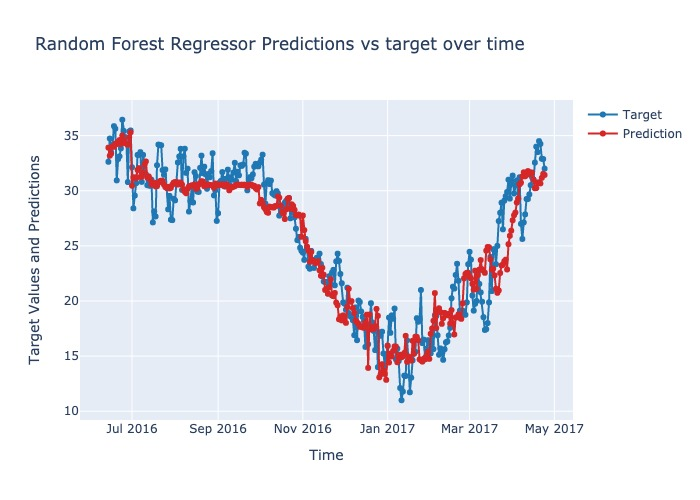

In [26]:
fig = evalml.model_understanding.graph_prediction_vs_actual_over_time(pipeline, 
                                                                      X_test, 
                                                                      y_test, 
                                                                      X_train, 
                                                                      y_train, 
                                                                      dates=X_test['date'])
fig.update_layout(title="Random Forest Regressor Predictions vs target over time")
fig.write_image("figures/random_forest.jpeg")
Image(filename="figures/random_forest.jpeg")

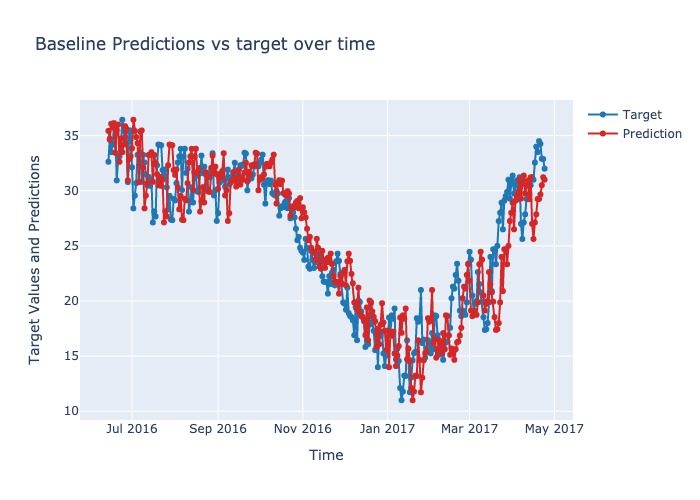

In [27]:
fig = evalml.model_understanding.graph_prediction_vs_actual_over_time(baseline, 
                                                                      X_test, 
                                                                      y_test, 
                                                                      X_train, 
                                                                      y_train, 
                                                                      dates=X_test['date'])
fig.update_layout(title="Baseline Predictions vs target over time")
fig.write_image("figures/baseline.jpeg")
Image(filename="figures/baseline.jpeg")

Notice how the prediction for the baseline run is essentially a shifted version of the target data. This makes sense, as the only feature used was a delayed version of the target data. Using more features--most specifically the rolling mean--we get predictions that are better, because they follow the rolling mean more tightly.

## Summarize Results

Below is a comparison of EvalML's model performance against the two manual runs. We can see that the manual and EvalML baseline models were nearly identical, and the models that employed feature engineering were both better, though EvalML slightly outperformed the Featuretools manual run.

From this we can see that, for time series problems, Featuretools and EvalML can improve model performance while also simplifying the steps to built the model.

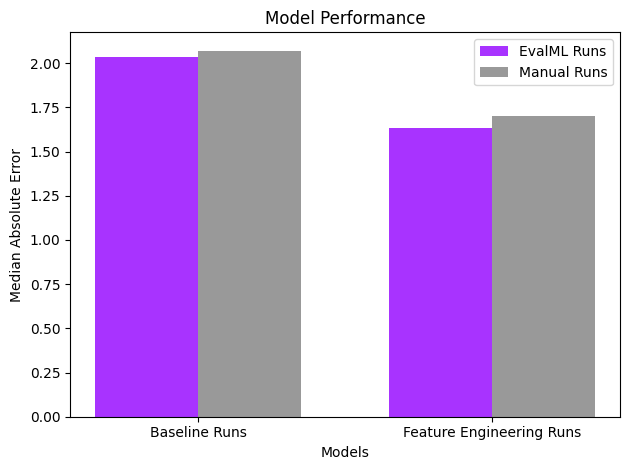

In [28]:
plot_model_performances(baseline_evalml_score, random_forest_evalml_score, baseline_score, featuretools_score)